In [1]:
#This is my model for generation of words on a partially masked corpus of text i.e. Twitch Data

In [2]:
#Utilizing Hugging Face
#https://huggingface.co/docs/transformers/quicktour

#Refs
#https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209

**Install Requirements**

In [2]:
# %pip install transformers datasets
# %pip install torch
# %from transformers import EncoderDecoderModel, BertTokenizer
# %pip freeze requirements.txt
# %pip install matplotlib
# %pip install numpy
# %pip install tensorflow
%pip install scikit-learn


  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\anish\Projects\twitchBot\venv\Scripts\python.exe -m pip install --upgrade pip' command.


**Imports**

In [4]:
import transformers
import torch
import os
import pandas as pd
import pickle as pkl
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

c:\Users\anish\Projects\twitchBot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Loading Data**

In [5]:
#Load Raw Data from StreamerData folder
#- Take certain number of files from data folder to use for generation

#Set this to the path of your data
folder_path = 'C:/Users/anish/Projects/twitchBot/streamerdata'

numFiles = 2

data = []

for i, file in enumerate(os.listdir(folder_path)):
    print("Adding file:", file)
    if i == numFiles - 1:
        break  
    with open(os.path.join(folder_path, file), 'rb') as f:
        curr_file = pkl.load(f)
        data.append(curr_file)

all_df = pd.concat(data, axis = 0)

Adding file: admiralbahroo.pkl
Adding file: admiralbulldog.pkl


In [6]:
#Display all_data
display(all_df.head())

#Print data columns
print([i for i in all_df.columns])

#Print size of data
print("Num Rows:", len(all_df))
print("Num Cols:", len(all_df.columns))


,body,channel_id,commenter_id,commenter_type,created_at,fragments,offset,updated_at,video_id
0,STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...,40972890,110969182,user,2018-06-24T17:07:43.067Z,"[{'text': 'STILL LATE STRIMMER IS A BAKA '}, {...",4.367,2018-06-24T17:07:43.067Z,277073045
1,NOT LIVE rooREE rooREE rooREE,40972890,109856709,user,2018-06-24T17:07:43.168Z,"[{'text': 'NOT LIVE '}, {'emoticon_id': '90487...",4.468,2018-06-24T17:07:43.168Z,277073045
2,rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...,40972890,56159955,user,2018-06-24T17:07:44.631Z,"[{'emoticon_id': '904818'}, {'text': ' BAHROOr...",5.931,2018-06-24T17:07:44.631Z,277073045
3,See,40972890,78678476,user,2018-06-24T17:07:45.602Z,[{'text': 'See'}],6.902,2018-06-24T17:07:45.602Z,277073045
4,rooPog,40972890,30898708,user,2018-06-24T17:07:45.802Z,[{'emoticon_id': '904866'}],7.102,2018-06-24T17:07:45.802Z,277073045


['body', 'channel_id', 'commenter_id', 'commenter_type', 'created_at', 'fragments', 'offset', 'updated_at', 'video_id']
Num Rows: 2722109
Num Cols: 9


**Data Preprocessing**

In [7]:
#Filter Data Frame by Strings that are longer than 3 -> Allow for masking
long_df = all_df[all_df['body'].apply(lambda x: len(x.split(' '))) > 3]

#Use small dataframe for testing efficiency's sake
long_df = long_df.iloc[:100]
print("Number of Rows:", len(long_df))

#Replace certain words with Mask token '[MASK]'
masked_arr = long_df.body.tolist()
for i in range(len(masked_arr)):

    add_mask = masked_arr[i].split(" ")
    mask_index = random.randint(0, len(add_mask) - 1)
    add_mask[mask_index] = '[MASK]'
    masked_arr[i] = " ".join(add_mask)


long_df['masked'] = masked_arr

display(long_df['masked'].head())

Number of Rows: 100


0    STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...
1                     [MASK] LIVE rooREE rooREE rooREE
2    rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...
7           rooHappy rooHappy [MASK] rooHappy rooHappy
8    rooREE LATE rooREE LATE rooREE LATE rooREE LAT...
Name: masked, dtype: object

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

# Define the model
class MaskedWordGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MaskedWordGenerator, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(vocab_size, activation='softmax')
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = tf.reduce_mean(x, axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# Generate training data
train_data = [
    "The quick brown fox jumps over the lazy dog",
    "The quick brown cat jumps over the lazy dog",
    "The quick brown dog jumps over the lazy fox",
    "The quick brown dog jumps over the lazy cat",
    "The quick brown fox jumps over the quick dog"
]

vocab = set()
for sentence in train_data:
    vocab.update(sentence.split())
    
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}
    
train_X = []
train_Y = []
for sentence in train_data:
    words = sentence.split()
    masked_word_idx = np.random.choice(len(words))
    masked_word = words[masked_word_idx]
    words[masked_word_idx] = '<MASK>'
    input_X = np.array([word_to_idx.get(word, 0) for word in words])
    train_X.append(input_X)
    output_Y = np.zeros((vocab_size,))
    for word in vocab:
        if word != masked_word:
            output_Y[word_to_idx[word]] = cosine_similarity(
                np.array([self.embedding([word_to_idx[masked_word]])]),
                np.array([self.embedding([word_to_idx[word]])])
            )[0][0]
    train_Y.append(output_Y)
    
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding='post')
train_Y = np.array(train_Y)

# Initialize the model and compile
model = MaskedWordGenerator(vocab_size, 50, 50)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model
model.fit(train_X, train_Y, epochs=50, batch_size=32)

# Generate masked word predictions
test_sentence = "The quick brown fox jumps over the lazy dog"
test_words = test_sentence.split()
masked_word_idx = np.random.choice(len(test_words))
masked_word = test_words[masked_word_idx]
test_words[masked_word_idx] = '<MASK>'
test_X = np.array([word_to_idx.get(word, 0) for word in test_words])
test_X = np.expand_dims(test_X, axis=0)
pred_Y = model.predict(test_X)[0]
pred_word_idx = np.argmax(pred_Y)
pred_word = idx_to_word[pred_word_idx]

print(f"Original sentence: {test_sentence}")
print(f"Masked sentence: {' '.join(test_words)}")
print(f"Predicted word: {pred_word}")

ModuleNotFoundError: No module named 'sklearn'

**Tokenizing**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Get Predictions**

0 Masked: STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka
0 Predicted: STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka STRIMMER IS A new rooBaka
1 Masked: NOT LIVE rooREE rooREE rooREE
1 Predicted: NOT ##te rooREE rooREE rooREE
2 Masked: rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROO
2 Predicted: rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka - BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROO
3 Masked: rooHappy rooHappy rooHappy rooHappy rooHappy
3 Predicted: rooHappy ! rooHappy rooHappy rooHappy
4 Masked: rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE ro

**Loss Metric**

Cosine similarity: 0.9177695512771606


Text(0.5, 0, 'Sentence #')

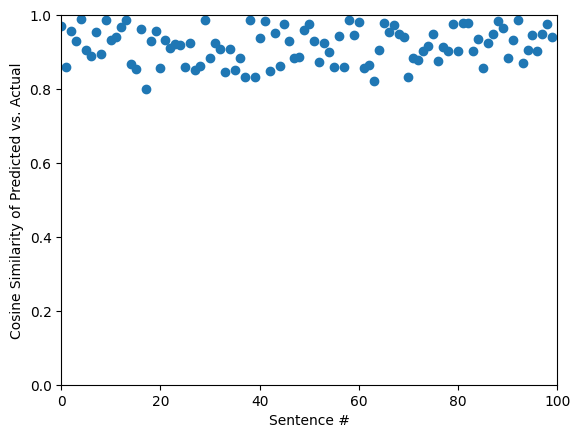

** Alternate Methodolgy of Calling Hugging Face Model **